# Problem Set \#6
## ECON 833, Computational Methods for Economists


## 1. Setup

In [1]:
# imports
from sklearn import tree
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint as sp_randint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read in data
df_biden=pd.read_csv('biden.csv',sep=',')
df_biden.head()

,biden,female,age,educ,dem,rep
0,90,0,19,12,1,0
1,70,1,51,14,1,0
2,60,0,27,14,0,0
3,50,1,43,14,1,0
4,60,1,38,14,0,1


In [3]:
# create y and X for reference later
y = df_biden['biden'].values
X_var_names = ['female', 'age', 'educ', 'dem', 'rep']
X = df_biden[X_var_names].values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size=0.3, random_state=25)

## 2. Basic Decision Tree

### 2.1 Fit a decision tree on the train data

In [5]:
dtr = tree.DecisionTreeRegressor(max_depth=3, min_samples_leaf=5)
biden_tree = dtr.fit(X_train, y_train)

### 2.2 Plot the tree

In [6]:
r = export_text(biden_tree, feature_names=X_var_names)
print(r)

|--- dem <= 0.50
|   |--- rep <= 0.50
|   |   |--- female <= 0.50
|   |   |   |--- value: [56.49]
|   |   |--- female >  0.50
|   |   |   |--- value: [61.27]
|   |--- rep >  0.50
|   |   |--- female <= 0.50
|   |   |   |--- value: [38.33]
|   |   |--- female >  0.50
|   |   |   |--- value: [44.89]
|--- dem >  0.50
|   |--- age <= 54.50
|   |   |--- educ <= 15.50
|   |   |   |--- value: [71.11]
|   |   |--- educ >  15.50
|   |   |   |--- value: [76.59]
|   |--- age >  54.50
|   |   |--- female <= 0.50
|   |   |   |--- value: [75.19]
|   |   |--- female >  0.50
|   |   |   |--- value: [80.29]



[Text(465.0, 792.75, 'dem <= 0.5\nmse = 556.262\nsamples = 1264\nvalue = 62.165'),
 Text(232.5, 566.25, 'rep <= 0.5\nmse = 507.397\nsamples = 724\nvalue = 52.811'),
 Text(116.25, 339.75, 'female <= 0.5\nmse = 444.551\nsamples = 468\nvalue = 58.868'),
 Text(58.125, 113.25, 'mse = 470.335\nsamples = 235\nvalue = 56.489'),
 Text(174.375, 113.25, 'mse = 407.088\nsamples = 233\nvalue = 61.266'),
 Text(348.75, 339.75, 'female <= 0.5\nmse = 432.623\nsamples = 256\nvalue = 41.738'),
 Text(290.625, 113.25, 'mse = 456.775\nsamples = 123\nvalue = 38.333'),
 Text(406.875, 113.25, 'mse = 389.649\nsamples = 133\nvalue = 44.887'),
 Text(697.5, 566.25, 'age <= 54.5\nmse = 347.197\nsamples = 540\nvalue = 74.706'),
 Text(581.25, 339.75, 'educ <= 15.5\nmse = 345.027\nsamples = 340\nvalue = 72.606'),
 Text(523.125, 113.25, 'mse = 369.301\nsamples = 247\nvalue = 71.105'),
 Text(639.375, 113.25, 'mse = 258.693\nsamples = 93\nvalue = 76.591'),
 Text(813.75, 339.75, 'female <= 0.5\nmse = 330.649\nsamples = 20

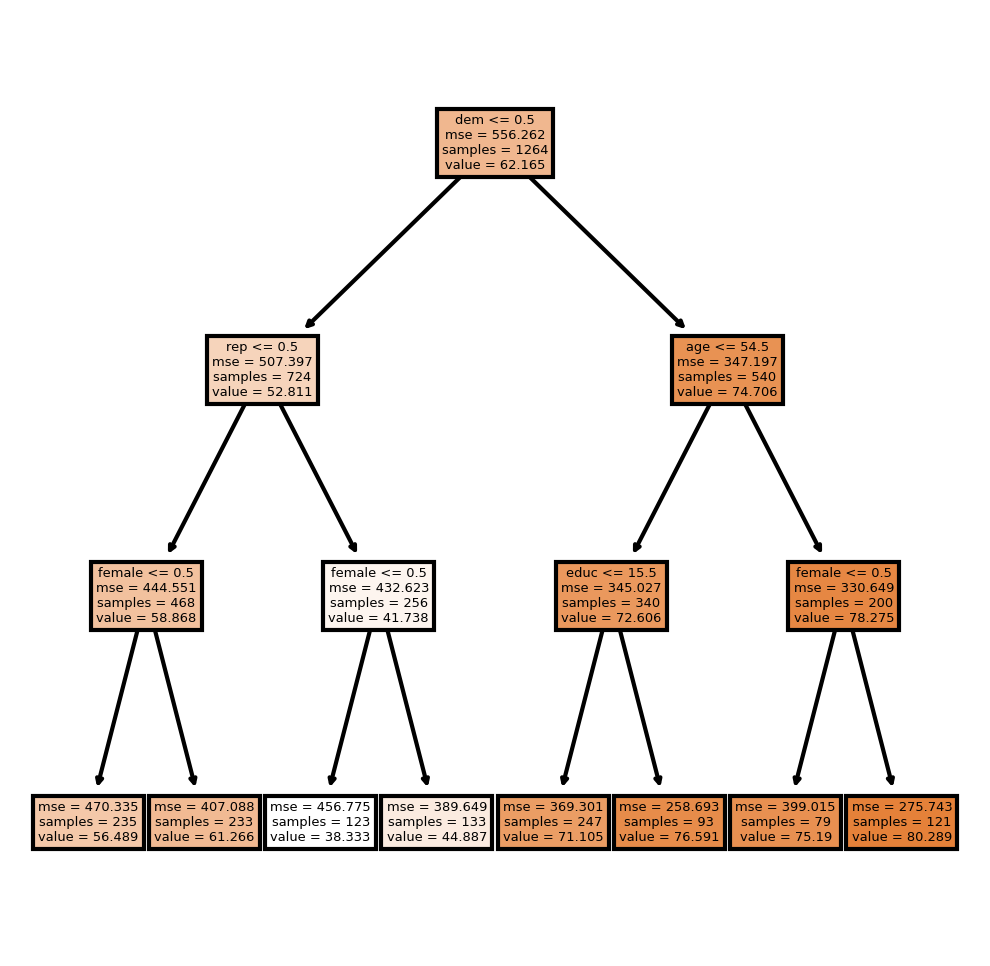

In [7]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(biden_tree, 
               feature_names=X_var_names, ax=axes, 
               filled = True)


### 2.3 Interpret the tree
- **Group1**: there are 235 male respondents who are neither Democrat nor Republican in this group. The mean value of feelings of warmth towards Biden is 56.489
- **Group2**: there are 233 female respondents who are neither Democrat nor Republican in this group. The mean value of feelings of warmth towards Biden is 61.266
- **Group3**: there are 123 male respondents who are not Democrat but Republican in this group. The mean value of feelings of warmth towards Biden is 38.333. The value is lowest in this group. i.e. Respondents in this group feel extremely cold for Biden
- **Group4**: there are 133 female respondents who are not Democrat but Republican in this group. The mean value of feelings of warmth towards Biden is 44.887
- **Group5**: there are 247 people in this group. They are Democrat, younger than 54.5 years old, and receive less than 15.5 years of formal education. The mean value of feelings of warmth towards Biden is 71.105
- **Group6**: there are 93 people in this group. They are Democrat, younger than 54.5 years old, and receive more than 15.5 years of formal education. The mean value of feelings of warmth towards Biden is 76.591
- **Group7**: there are 79 people in this group. They are male, Democrat, older than 54.5 years old. The mean value of feelings of warmth towards Biden is 75.19
- **Group8**: there are 121 people in this group. They are female, Democrat, older than 54.5 years old. The mean value of feelings of warmth towards Biden is 80.289. Therefore, in this sample, people with those characteristics support Biden the most.


### 2.4 MSE

In [8]:
# use test data to calculate the predicted y
y_predict = biden_tree.predict(X_test)

In [9]:
MSE = mean_squared_error(y_test, y_predict)
print('The SSE of a tree of depth ', biden_tree.get_depth(), ' and ',
      biden_tree.get_n_leaves(), ' leaves = ', MSE)

The SSE of a tree of depth  3  and  8  leaves =  396.1937146321307


## 3. Optimal Tuning Parametes

### 3.1 Set parameter distributions

In [10]:
param_dist = {"max_depth": [3, 10], 
              "min_samples_split": sp_randint(2, 20),
              "min_samples_leaf": sp_randint(2, 20)}


### 3.2 Fit the model

In [11]:
clf = RandomizedSearchCV(estimator=dtr, 
                         param_distributions=param_dist, 
                         n_iter=100, n_jobs=-1, cv=5, #k = 5 k-fold cross validation
                         random_state=25, 
                         scoring='neg_mean_squared_error')
search = clf.fit(X,y)

### 3.3 Find the optimal parameters and MSE for the optimal result

In [12]:
optimal_tuning_params = search.best_params_
MSE_optimalRes = -search.best_score_


### 3.4 Report the result

In [13]:
# Report the optimal tuning parameter values
print("The optimal maximum depth for this model is %s" %  optimal_tuning_params.get('max_depth'))
print("The optimal mininum samples split for this model is %s" %  optimal_tuning_params.get('min_samples_split'))
print("The optimal mininum samples leaf for this model is %s" %  optimal_tuning_params.get('min_samples_leaf'))

# Report the MSE of the optimal results 
print("The MSE of the optimal results is %s" % MSE_optimalRes)

The optimal maximum depth for this model is 3
The optimal mininum samples split for this model is 14
The optimal mininum samples leaf for this model is 17
The MSE of the optimal results is 401.713307249986


## 4. Random Forest

### 4.1 Set parameter distributions

In [14]:
param_dist_rf = {"n_estimators": [10, 200], 
              "max_depth": [3, 10],
              "min_samples_split": sp_randint(2, 20), 
              "min_samples_leaf": sp_randint(2, 20),
              "max_features": sp_randint(1, 5)}

### 4.2 Fit the model

In [15]:
rf = RandomForestRegressor()
clf_randamForest = RandomizedSearchCV(estimator=rf, 
                         param_distributions=param_dist_rf, 
                         n_iter=100, n_jobs=-1, cv=5, #k = 5 k-fold cross validation
                         random_state=25, 
                         scoring='neg_mean_squared_error')
search_rf = clf_randamForest.fit(X,y)

### 3.3 Find the optimal parameters and MSE for the optimal result

In [16]:
optimal_tuning_params_rf = search_rf.best_params_
MSE_optimalRes_rf = -search_rf.best_score_

### 3.4 Report the result

In [17]:
# Report the optimal tuning parameter values
print("The optimal number of estimators for this model is %s" %  optimal_tuning_params_rf.get('n_estimators'))
print("The optimal maximum depth for this model is %s" %  optimal_tuning_params_rf.get('max_depth'))
print("The optimal mininum samples split for this model is %s" %  optimal_tuning_params_rf.get('min_samples_split'))
print("The optimal mininum samples leaf for this model is %s" %  optimal_tuning_params_rf.get('min_samples_leaf'))
print("The optimal maximum features for this model is %s" %  optimal_tuning_params_rf.get('max_features'))

# Report the MSE of the optimal results 
print("The MSE of the optimal results is %s" % MSE_optimalRes_rf)

The optimal number of estimators for this model is 200
The optimal maximum depth for this model is 3
The optimal mininum samples split for this model is 4
The optimal mininum samples leaf for this model is 19
The optimal maximum features for this model is 3
The MSE of the optimal results is 397.05747445504363
